In [2]:
import micropip
await micropip.install(["kaibu-utils", "pyotritonclient>=0.1.7"])

In [12]:
from js import fetch
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import pickle
import imageio
import asyncio
import os
from pyotritonclient import SequenceExcutor, execute
from kaibu_utils import features_to_mask, mask_to_features, fetch_image


def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

async def cellpose_segment(image, diameter=100):
    results = await execute([image.transpose(2, 0, 1), {'diameter': diameter}],
                server_url='https://ai.imjoy.io/triton',
                model_name='cellpose-python',
                decode_bytes=True)
    mask = results['mask'][0].copy()
    return mask

def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

async def download_data(url):
    response = await fetch(url)
    bytes = await response.arrayBuffer()
    bytes = bytes.to_py()
    buffer = io.BytesIO(bytes)
    return pickle.load(buffer)

async def train_once(model_id, image, labels, steps=16, model_token=None, resume=True, pretrained_model="cyto", channels=None, diameter=100):
    """
    Train a cellpose model through the BioEngine
    # set pretrained_model to None if you want to train from scratch
    # set model_token to a string if you want to protect the model
    # from overwriting by other users
    """
    seq = SequenceExcutor(
        server_url="https://ai.imjoy.io/triton",
        model_name="cellpose-train",
        decode_json=True,
        sequence_id=model_id,
    )
    if not channels:
        channels = [1, 2]
    if labels.ndim == 2:
        labels = labels[:, :, None]
    inputs = [
        image.astype("float32"),
        labels.astype("uint16"),
        {
            "steps": steps,
            "pretrained_model": pretrained_model,
            "resume": resume,
            "model_token": model_token,
            "channels": channels,
            "diam_mean": 30,
        },
    ]
    result = await seq.step(inputs, select_outputs=["info"])
    loss = result["info"][0]["loss"]
    print(f"loss={loss}")
    await seq.end()
    return loss

async def predict(model_id, image, channels=None, diameter=100, reload=False):
    """Make predition with the specified cellpose model"""
    # Start the prediction
    seq = SequenceExcutor(
        server_url="https://ai.imjoy.io/triton",
        model_name="cellpose-predict",
        decode_json=True,
        sequence_id=model_id,
    )
    if not channels:
        channels = [1, 2]

    inputs = [image.astype("float32"), {"channels": channels, "diameter": diameter, "reload": reload}]
    results = await seq.step(inputs, select_outputs=["mask"])
    # await seq.end()
    return results['mask'][:, :, 0]

async def download_model(model_id, samples, model_token = None):
    """
    Download the trained model by its id.
    """
    seq = SequenceExcutor(
        server_url="https://ai.imjoy.io/triton",
        model_name="cellpose-train",
        decode_json=True,
        sequence_id=model_id,
    )
    valid_image, valid_labels = samples[0]
    result = await seq.end(
        [
            valid_image.astype("float32"),
            valid_labels.astype("uint16"),
            {
                "resume": True,
                "model_token": model_token,
                "channels": [1, 2],
                "diameter": 100.0,
                "model_format": "bioimageio",
            },
        ],
        decode_json=True,
        select_outputs=["info", "model"],
    )
    # Save the weights
    model_package = result["model"][0]
    filename = result["info"][0]["model_files"][0]
    with open(os.path.join(os.path.expanduser('~'), filename), "wb") as fil:
        fil.write(model_package)
    print(f"Model package saved to {filename}")


(512, 512, 3)


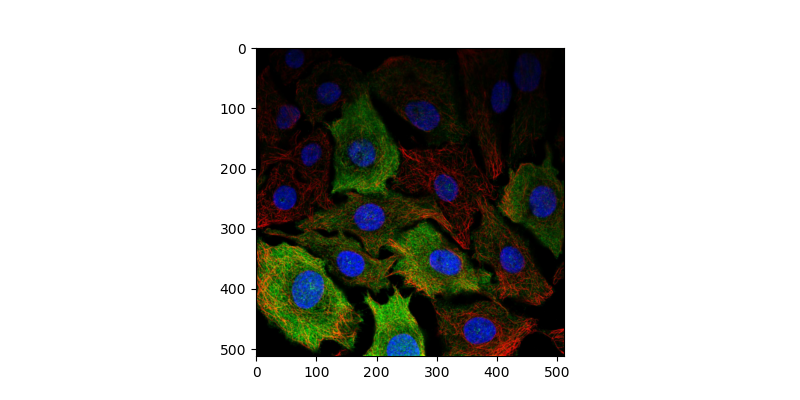

In [13]:
image = await fetch_image("https://images.proteinatlas.org/61448/1319_C10_2_blue_red_green.jpg")
image = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True).astype('float32')
print(image.shape)
plt.imshow(image.astype('uint8'))
plt.show()

In [14]:
await train_once(106, image, mask)

loss=0.3224737923592329


0.3224737923592329

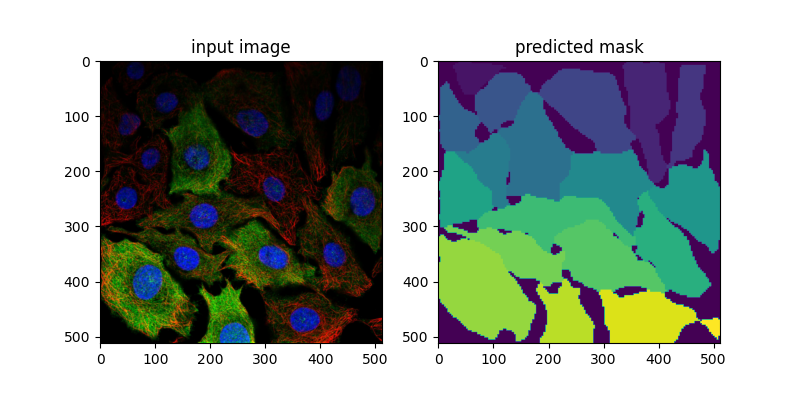

In [16]:
mask = await predict(106, image, reload=True)
display_image(image.astype('uint8'), mask)

In [17]:
from imjoy import api

model_id = 106

class ImJoyPlugin():
    async def setup(self):
        viewer = await api.createWindow(src="https://kaibu.org/#/app")
        
        # Add an image layer and annotation layer
        await viewer.view_image(image.astype('uint8'))
        # annotation_layer = await viewer.add_shapes([], {"name": "annotation"})
        self.annotation_layer = None
        async def do_prediction():
            mask = await predict(model_id, image, reload=True)
            # await viewer.view_image(mask, name="mask")
            polygons = mask_to_features(mask)
            self.annotation_layer = await viewer.add_shapes(
                polygons,
                shape_type="polygon",
                edge_color="red",
                name="prediction",
            )

        async def train_once():
            features = await self.annotation_layer.get_features()
            mask = features_to_mask(features, image.shape[:2])
            loss = await train_once(model_id, image, mask)
            await api.showMessage(f"Loss: {loss}")

        await viewer.add_widget(
        {
            "_rintf": True,
            "name": "Control",
            "type": "control",
            "elements": [
                {
                    "type": "button",
                    "label": "Do Prediction",
                    "callback": do_prediction,
                },
                {
                    "type": "button",
                    "label": "Train Once",
                    "callback": train_once,
                },
            ],
        })

api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>

<Future finished result=[]>